In [89]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
BATCH_SIZE = 5
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

Found 1086 files belonging to 2 classes.
(5, 256, 256, 3)
[1 1 1 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

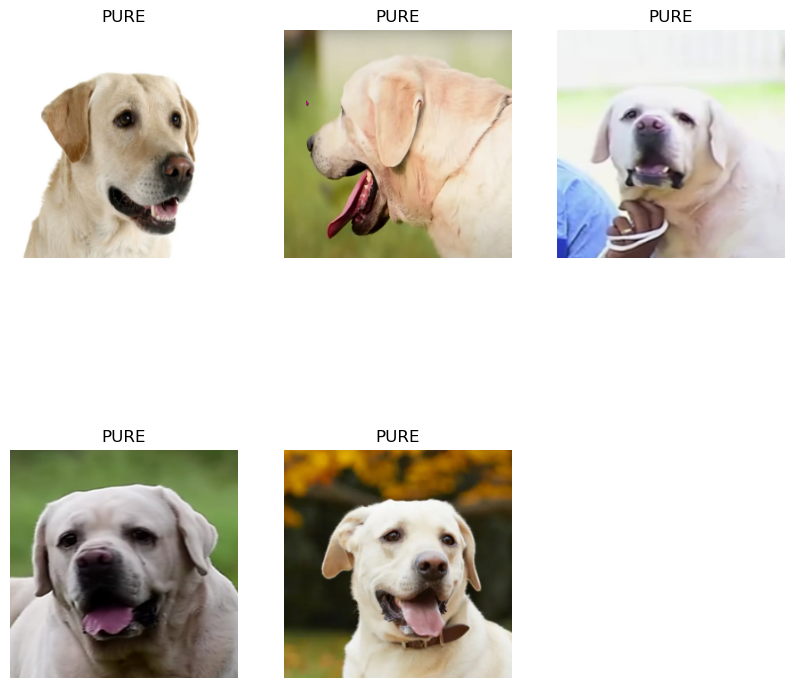

In [62]:
for image_batch, labels_batch in dataset.take(1):
    batch_size = len(image_batch)  # Batch size is 5
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):  # Only loop through available images
        ax = plt.subplot(2, 3, i + 1)  # Adjust the grid to fit 5 images
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    plt.show()


In [63]:
len(dataset)

218

In [64]:
train_size = 0.8
len(dataset)*train_size

174.4

In [65]:
train_ds = dataset.take(54)
len(train_ds)

54

In [66]:
test_ds = dataset.skip(54)
len(test_ds)

164

In [67]:
val_size=0.1
len(dataset)*val_size

21.8

In [68]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [69]:
test_ds = test_ds.skip(6)
len(test_ds)

158

In [70]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [71]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [72]:
len(train_ds)

len(val_ds)

len(test_ds)

23

### Cache, Shuffle, and Prefetch the Dataset

In [73]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [74]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [81]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [82]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [83]:
from tensorflow.keras import layers, models

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Exclude batch size here
n_classes = 2

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Define the input shape explicitly
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# No need to call model.build(input_shape), Sequential handles it
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,242 (28.48 MB)

 Trainable params: 7,466,242 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [85]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop training after 5 epochs of no improvement
    restore_best_weights=True # Restore the weights of the best epoch
)

# Training the Network with EarlyStopping
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)


Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.5316 - loss: 0.7000 - val_accuracy: 0.6476 - val_loss: 0.5416
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 254ms/step - accuracy: 0.6790 - loss: 0.5847 - val_accuracy: 0.5714 - val_loss: 0.6082
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.7029 - loss: 0.5561 - val_accuracy: 0.8190 - val_loss: 0.5074
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.7792 - loss: 0.5069 - val_accuracy: 0.7333 - val_loss: 0.5968
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.7657 - loss: 0.4956 - val_accuracy: 0.7810 - val_loss: 0.4834
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.8115 - loss: 0.4614 - val_accuracy: 0.8190 - val_loss: 0.5108
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.7757 - loss: 0.5163 - val_accuracy: 0.8095 - val_loss: 0.4527
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.7675 - loss: 0

In [87]:
scores = model.evaluate(test_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9479 - loss: 0.1901


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


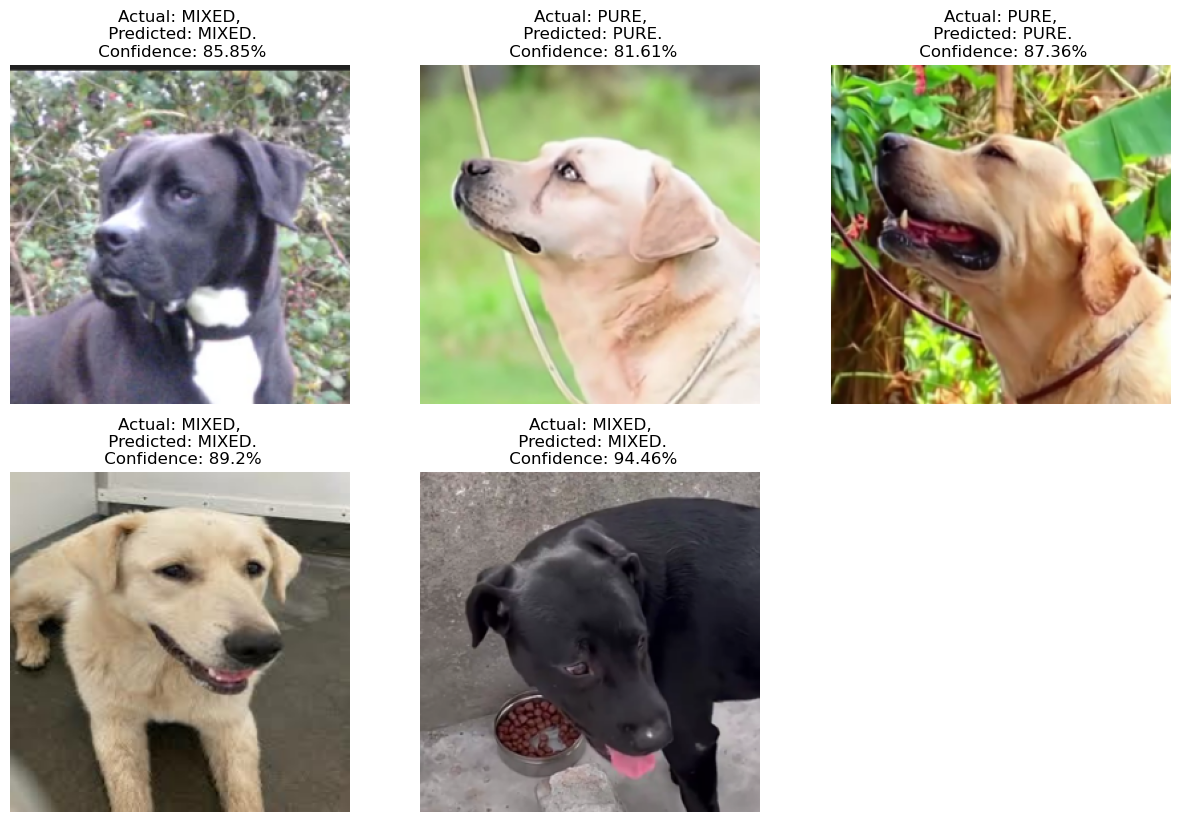

In [90]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
# Visualize predictions on the test set
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    num_images = min(9, images.shape[0])  # Ensure we only show up to 9 images
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


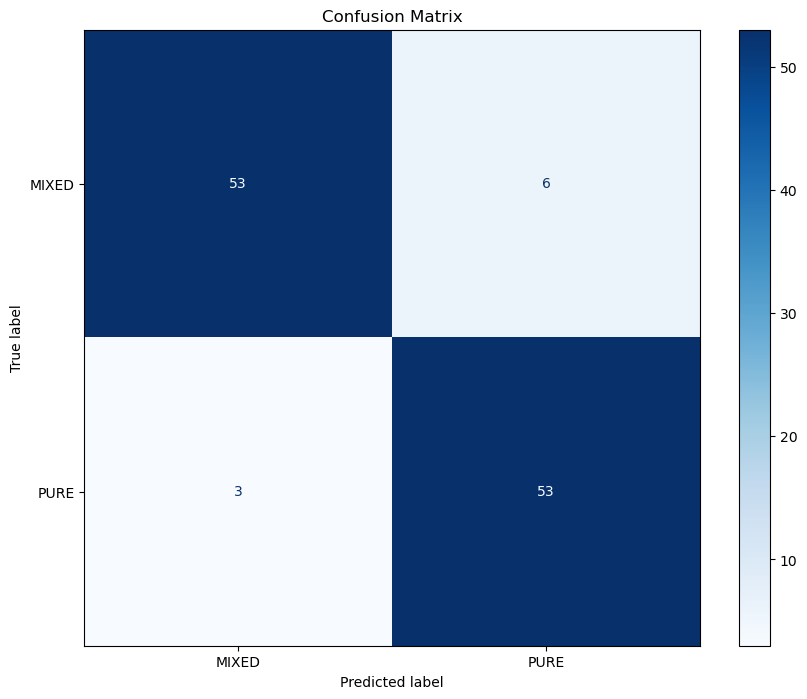

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Collect predictions and actual labels from the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()


In [92]:
scores

[0.24911482632160187, 0.9217391014099121]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [93]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [94]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 174}

In [95]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [96]:
type(history.history['loss'])

list

In [97]:
len(history.history['loss'])

17

In [98]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6458716988563538,
 0.5916252732276917,
 0.5567015409469604,
 0.5112595558166504,
 0.5225657224655151]

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

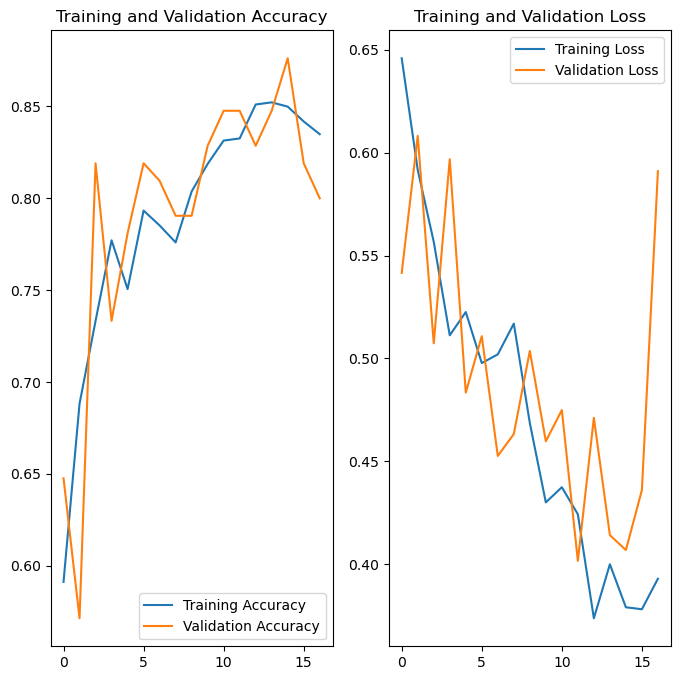

In [102]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(17), acc, label='Training Accuracy')
plt.plot(range(17), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(17), loss, label='Training Loss')
plt.plot(range(17), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: PURE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted label: PURE


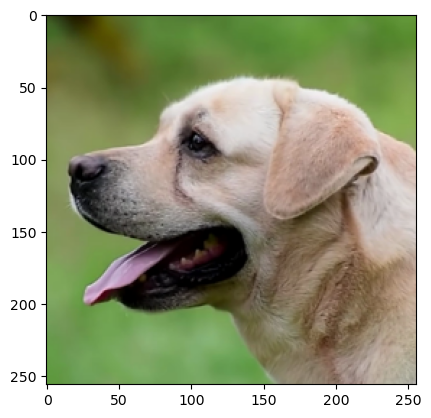

In [108]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [104]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


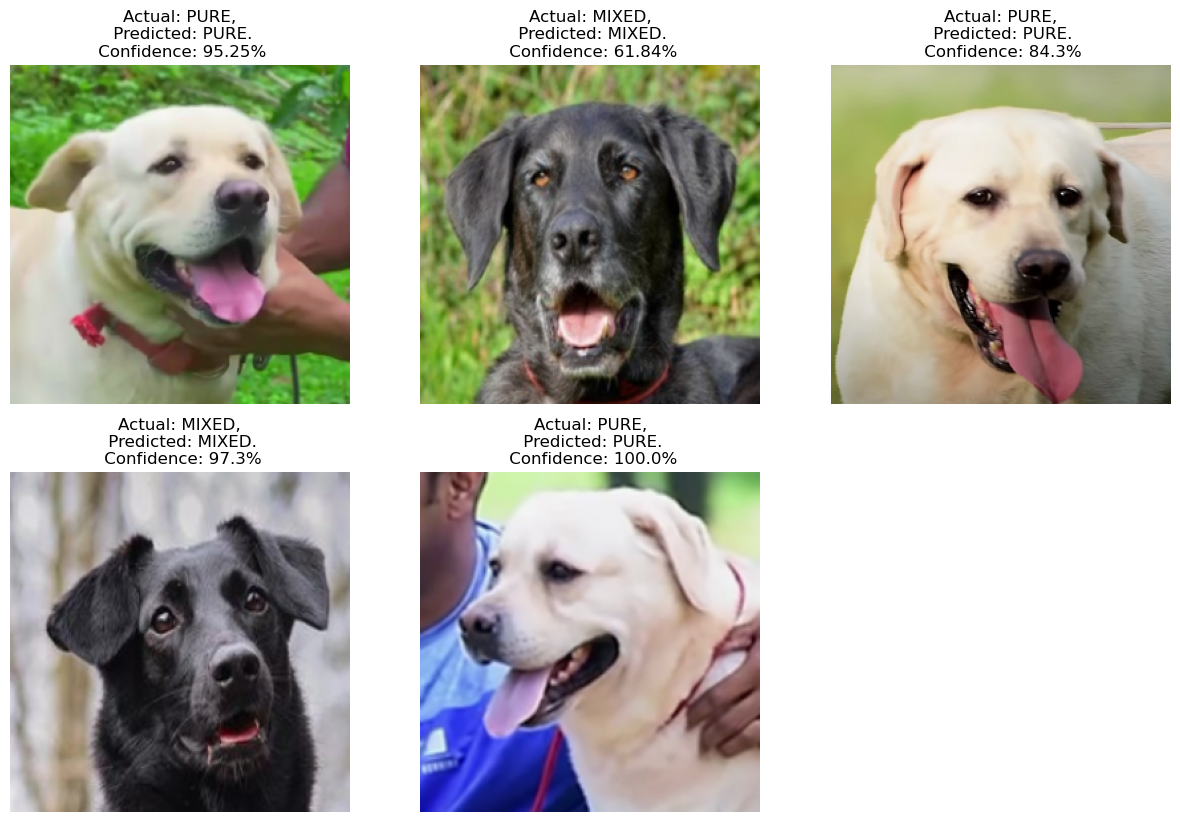

In [109]:
import matplotlib.pyplot as plt

# Fetch a batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    # Get the number of images in the batch
    num_images = images.shape[0]
    
    # Set up the plot with the number of images available (max 9)
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, 9)):  # Ensure we don't go beyond the batch size
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict the class and confidence
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # Set the title
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    
    plt.show()


In [107]:
import os
from keras.models import load_model

# Define the directory name and model name
model_directory = 'D:/SAVED'
model_filename = '94%.keras'

# Create the directory if it does not exist
os.makedirs(model_directory, exist_ok=True)

# Save the model as an HDF5 file in the specified directory
model.save(os.path.join(model_directory, model_filename))

# To load the model later, you can use:
# loaded_model = load_model(os.path.join(model_directory, model_filename))
